This notebook is used to find the best model architectures for each dataset locally, or rather on Google Cloud due to GPU availability. The models are being retrained every once in a while in order to adapt to the change of distribution and data availability. 

## Google Colab utils (set GPU!)

In [ ]:
!pip install keras-tuner

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/air-pollution-app"

# Modeling

In [1]:
import warnings
warnings.filterwarnings('ignore')

from models import *
from config import *
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_utils import *

### 0. Download the data

In [2]:
# training_data_pipeline()

In [3]:
# for station in SENSORS:
#     train_encoder_input_data = np.load(f'./data/training/third-order/{station}/train_encoder_input_data.npy')
#     valid_encoder_input_data = np.load(f'./data/training/third-order/{station}/valid_encoder_input_data.npy')
    
#     print(f'{station}:', train_encoder_input_data.shape[0], '-', valid_encoder_input_data.shape[0])

### 1. Load the data

In [4]:
# Set the station
station = 'Centar'

In [5]:
train_encoder_input_data = np.load(f'./data/training/third-order/{station}/train_encoder_input_data.npy')
train_decoder_input_data = np.load(f'./data/training/third-order/{station}/train_decoder_input_data.npy')
train_decoder_target_data = np.load(f'./data/training/third-order/{station}/train_decoder_target_data.npy')

valid_encoder_input_data = np.load(f'./data/training/third-order/{station}/valid_encoder_input_data.npy')
valid_decoder_input_data = np.load(f'./data/training/third-order/{station}/valid_decoder_input_data.npy')
valid_decoder_target_data = np.load(f'./data/training/third-order/{station}/valid_decoder_target_data.npy')

In [6]:
print(train_encoder_input_data.shape, train_decoder_input_data.shape, train_decoder_target_data.shape)
print(valid_encoder_input_data.shape, valid_decoder_input_data.shape, valid_decoder_target_data.shape)

(57900, 24, 23) (57900, 12, 21) (57900, 12, 2)
(9529, 24, 23) (9529, 12, 21) (9529, 12, 2)


In [7]:
# due to the model architecture, we need to transform the output shape and type
train_attentive_decoder_target_data = list(np.swapaxes(
                                              train_decoder_target_data, 0, 1))
valid_attentive_decoder_target_data = list(np.swapaxes(
                                              valid_decoder_target_data, 0, 1))

In [8]:
m_train, Tx, encoder_input_dim = train_encoder_input_data.shape
    
Ty, decoder_input_dim = (train_decoder_input_data.shape[1], 
                         train_decoder_input_data.shape[2])

decoder_output_dim = train_decoder_target_data.shape[2]

m_val = valid_encoder_input_data.shape[0]

In [9]:
batch_size = 64
epochs = 100
patience = 10
max_trials = 200
executions_per_trial = 1

### 2. Random search

Make sure to delete the keras-tuner dir for every random search.

In [10]:
model_builder = HyperAttentiveSeq2Seq(Tx, Ty, encoder_input_dim, decoder_input_dim,
                                decoder_output_dim)
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=max_trials,
                     executions_per_trial=executions_per_trial,
                     directory='keras-tuner', 
                     project_name=station)

**If an epoch takes longer than 3 minutes, you probably forgot to set GPU :))**

In [ ]:
tuner.search(x=[train_encoder_input_data, 
                train_decoder_input_data], 
             y=train_attentive_decoder_target_data,
             validation_data=([
                valid_encoder_input_data,
                valid_decoder_input_data],
                valid_attentive_decoder_target_data),
             batch_size=batch_size,
             epochs=epochs,
             verbose=0,
             callbacks=[EarlyStopping(monitor='val_loss', 
                                      patience=patience, 
                                      verbose=1),
                        LossPrintingCallback()])

Traceback (most recent call last):
  File "/home/zafir/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 2326, in get_attr
    c_api.TF_OperationGetAttrValueProto(self._c_op, name, buf)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Operation 'split_2' has no attr named '_XlaCompile'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zafir/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/ops/gradients_util.py", line 331, in _MaybeCompile
    xla_compile = op.get_attr("_XlaCompile")
  File "/home/zafir/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 2330, in get_attr
    raise ValueError(str(e))
ValueError: Operation 'split_2' has no attr named '_XlaCompile'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

In [ ]:
tuner.results_summary()

### 3. Training the best-performing model

In [10]:
# best hyperparameters
hp = best_hyperparameters[station]
encoder_latent_dim = hp['encoder_latent_dim']
decoder_latent_dim = hp['decoder_latent_dim']
attention_dense_dim = hp['attention_dense_dim']
seq_dropout_rate = hp['seq_dropout_rate']
dense_dropout_rate = hp['dense_dropout_rate']
learning_rate = hp['learning_rate']

In [11]:
h0_train = np.zeros((m_train, decoder_latent_dim))
c0_train = np.zeros((m_train, decoder_latent_dim))

h0_val = np.zeros((m_val, decoder_latent_dim))
c0_val = np.zeros((m_val, decoder_latent_dim))

In [12]:
model_builder = AttentiveSeq2SeqModelBuilder(Tx, Ty, encoder_input_dim, 
                                             decoder_input_dim, decoder_output_dim, 
                                             len(SENSORS[station]), encoder_latent_dim, 
                                             decoder_latent_dim, attention_dense_dim, 
                                             seq_dropout_rate, dense_dropout_rate, 
                                             learning_rate)

In [13]:
model = model_builder.build_training_attentive_model()

In [14]:
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
    
if os.path.exists(f'./checkpoints/{station}.h5'):
    os.remove(f'./checkpoints/{station}.h5')

history = model.fit(x=[train_encoder_input_data, 
                       train_decoder_input_data,
                       h0_train, c0_train], 
                    y=train_attentive_decoder_target_data,
                    validation_data=([
                       valid_encoder_input_data,
                       valid_decoder_input_data, 
                       h0_val, c0_val],
                       valid_attentive_decoder_target_data),
                    batch_size=batch_size,
                    epochs=2,
                    verbose=0,
                    callbacks=[LossPrintingCallback(),
                               ModelCheckpoint(f'./checkpoints/{station}.h5',
                                               save_best_only=True),
                               EarlyStopping(monitor='val_loss', 
                                             patience=patience, 
                                             verbose=1)])

[2020-07-21 17:49:11]	epoch: 0	loss: 1.99707	val_loss:1.79687
[2020-07-21 17:50:31]	epoch: 1	loss: 1.57304	val_loss:1.74051


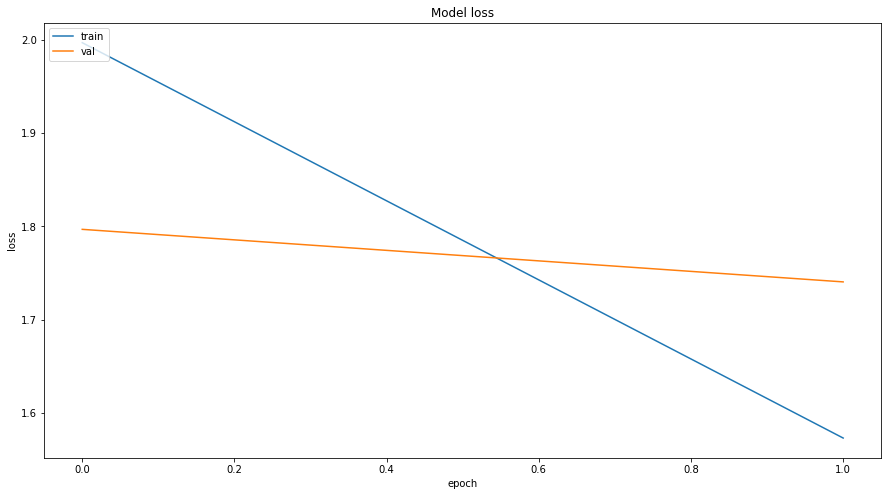

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 4. Build and save the inference model

In [16]:
K.clear_session()
best_model = load_model(f'./checkpoints/{station}.h5')

In [17]:
model = model_builder.build_inference_attentive_model(best_model)

In [18]:
if not os.path.exists('./inference-models'):
    os.makedirs('./inference-models')
    
if os.path.exists(f'./inference-models/{station}.h5'):
    os.remove(f'./inference-models/{station}.h5')
    
model.save(f'./inference-models/{station}.h5')

In [19]:
model = load_model(f'./inference-models/{station}.h5')